In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split


### Generate the data and convert to torch instance 

In [3]:

# Generate dataset with 2000 instances, 3 features, and 1 output
X, y = make_regression(n_samples=2000, n_features=3, n_targets=1, noise=0.1, random_state=42)

# Split the data: 1500 for training, 500 for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1500, test_size=500, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)  # unsqueeze for single output dimension
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Create TensorDataset and DataLoader for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



### Define the model

In [4]:
# Define the neural network architecture
class SmallRegressionNN(nn.Module):
    def __init__(self):
        super(SmallRegressionNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 4),  # Input layer
            nn.ReLU(),
            nn.Linear(4, 4),  # Hidden layer
            nn.ReLU(),
            nn.Linear(4, 4),  # Hidden layer
            nn.ReLU(),
            nn.Linear(4, 4),  # Hidden layer
            nn.ReLU(),
            nn.Linear(4, 1)   # Output layer
        )

    def forward(self, x):
        return self.layers(x)

# Instantiate the model, define loss function and optimizer
model = SmallRegressionNN()
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)



### Train the model

In [5]:
# Training parameters
epochs = 100
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()           # Clear gradients
        outputs = model(inputs)         # Forward pass
        loss = criterion(outputs, targets)  # Calculate loss
        loss.backward()                 # Backpropagation
        optimizer.step()                # Update weights
        running_loss += loss.item() * inputs.size(0)  # Accumulate loss
    
    # Print average loss for the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/100], Loss: 2480.0439
Epoch [2/100], Loss: 2479.5986
Epoch [3/100], Loss: 2478.0537
Epoch [4/100], Loss: 2473.2480
Epoch [5/100], Loss: 2462.6209
Epoch [6/100], Loss: 2441.9317
Epoch [7/100], Loss: 2398.9132
Epoch [8/100], Loss: 2315.0804
Epoch [9/100], Loss: 2166.4359
Epoch [10/100], Loss: 1943.9181
Epoch [11/100], Loss: 1679.3634
Epoch [12/100], Loss: 1443.1480
Epoch [13/100], Loss: 1291.4404
Epoch [14/100], Loss: 1200.3135
Epoch [15/100], Loss: 1141.4653
Epoch [16/100], Loss: 1095.6698
Epoch [17/100], Loss: 1042.8042
Epoch [18/100], Loss: 884.4933
Epoch [19/100], Loss: 584.4993
Epoch [20/100], Loss: 299.1165
Epoch [21/100], Loss: 172.0680
Epoch [22/100], Loss: 132.7865
Epoch [23/100], Loss: 114.5859
Epoch [24/100], Loss: 103.0739
Epoch [25/100], Loss: 93.6713
Epoch [26/100], Loss: 85.9734
Epoch [27/100], Loss: 78.8571
Epoch [28/100], Loss: 73.1952
Epoch [29/100], Loss: 67.5533
Epoch [30/100], Loss: 64.1492
Epoch [31/100], Loss: 58.8098
Epoch [32/100], Loss: 54.8800
Epoch [3

### Test the model 

In [6]:
# Switch to evaluation mode
model.eval()
predictions = []
actuals = []

with torch.no_grad():  # No need to compute gradients
    for inputs, targets in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())  # Append predictions
        actuals.extend(targets.squeeze().tolist())      # Append actual values

# Convert predictions and actuals to lists and calculate metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
r2 = r2_score(actuals, predictions)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"R-squared: {r2:.4f}")


Mean Squared Error: 0.7438
Mean Absolute Error: 0.4675
R-squared: 0.9997


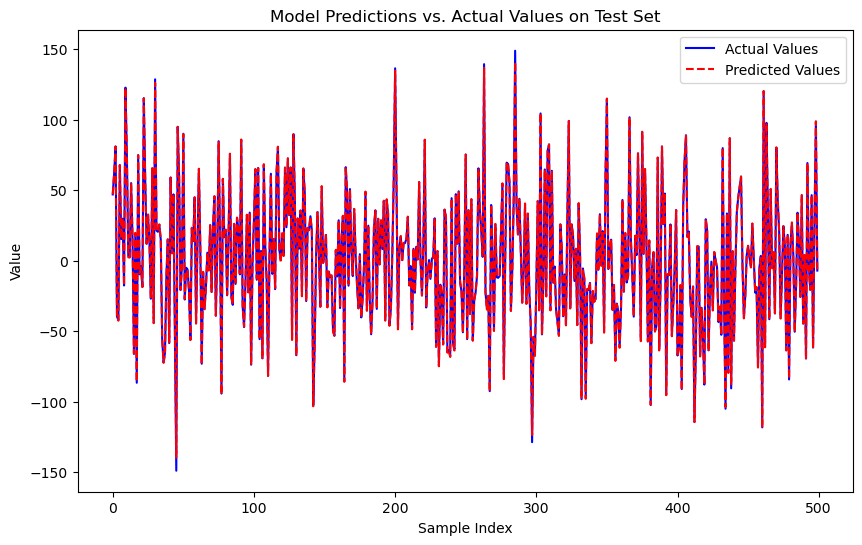

In [7]:
# Convert predictions and actuals to NumPy arrays for plotting
predictions = np.array(predictions)
actuals = np.array(actuals)

# Plot the predictions vs. actual values
plt.figure(figsize=(10, 6))
plt.plot(actuals, label='Actual Values', linestyle='-', color='b', markersize=4)
plt.plot(predictions, label='Predicted Values',  linestyle='--', color='r', markersize=4)
plt.title('Model Predictions vs. Actual Values on Test Set')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.legend()
plt.show()



In [8]:
# Define the file path
file_path = 'data/regression_test_71.txt'

# Combine features and output for each test instance
test_data = np.hstack((X_test, y_test.reshape(-1, 1)))

# Save to file without brackets
with open(file_path, 'w') as f:
    for row in test_data:
        # Write row as a comma-separated line without brackets
        f.write(", ".join(map(str, row)) + "\n")

print(f"Test data saved to {file_path}")

# Define the full path for saving the model
model_path = 'model/pth/regression_model_71.pth'

# Save the model parameters
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

# Define the path for the ONNX file
onnx_path = 'model/onnx/regression_model_71.onnx'

# Specify a dummy input to trace the model's structure
dummy_input = torch.randn(1, 3)  # Adjust the shape (1, 3) based on your model's input requirements

# Export the model to ONNX format
torch.onnx.export(
    model,                        # Model to be exported
    dummy_input,                  # Dummy input tensor to define the input size
    onnx_path,                    # Path to save the ONNX model
    export_params=True,           # Store the trained parameter weights inside the model file
    opset_version=11,             # ONNX version to export to
    input_names=['input'],        # Name of the input layer
    output_names=['output'],      # Name of the output layer
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}  # Dynamic batching
)

print(f"Model saved in ONNX format to {onnx_path}")


Test data saved to data/regression_test_71.txt
Model saved to model/pth/regression_model_71.pth
Model saved in ONNX format to model/onnx/regression_model_71.onnx
